In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [2]:
def load_and_prep_cifar(batch_size, shuffle_buffer_size):
    train, test = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

    def preprocessing_func(img, label):
        img = tf.cast(img, tf.float32)
        img = (img / 128) - 1
        label = tf.one_hot(label, depth=10)
        return img, label

    train = train.map(lambda img, label: preprocessing_func(img, label))
    test = test.map(lambda img, label: preprocessing_func(img, label))

    train = train.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(2)
    test = test.batch(batch_size).prefetch(2)

    return train, test


In [3]:
# Set hyperparameters
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000
LR = 0.0001
NUM_EPOCHS = 100

In [4]:
# Load and preprocess the data
train_data, test_data = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)

# # Visualize a sample from the training dataset
# sample_batch = next(iter(train_data))
# images, labels = sample_batch

# plt.figure(figsize=(10, 10))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy() / 2 + 0.5)  # Rescale images to [0, 1]
#     plt.title(f"Label: {tf.argmax(labels[i]).numpy()}")
#     plt.axis("off")
# plt.show()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteFA6W2T/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteFA6W2T/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
def train_cifar_10(model, train_ds, test_ds, num_epochs, lr):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
    test_loss = tf.keras.metrics.Mean(name='test_loss')
    test_accuracy = tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, predictions)

    @tf.function
    def test_step(images, labels):
        predictions = model(images)
        t_loss = loss_object(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

    for epoch in range(num_epochs):
        # Training loop
        for images, labels in train_ds:
            train_step(images, labels)

        # Testing loop
        for test_images, test_labels in test_ds:
            test_step(test_images, test_labels)

        # Save metrics for plotting
        train_losses.append(train_loss.result().numpy())
        train_accuracies.append(train_accuracy.result().numpy())
        test_losses.append(test_loss.result().numpy())
        test_accuracies.append(test_accuracy.result().numpy())

        template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
        print(template.format(epoch + 1,
                              train_loss.result(),
                              train_accuracy.result() * 100,
                              test_loss.result(),
                              test_accuracy.result() * 100))

        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

    # Plotting
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
# Define and compile the model
def create_my_cifar_cnn(name='my_cnn'):
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)

    cnn_layer_1_1= tf.keras.layers.Conv2D(filters = 16, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_1_1(inputs)#shape: [batch_size, 32,32,16]

    cnn_layer_1_2= tf.keras.layers.Conv2D(filters = 16, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_1_2(x)#shape: [batch_size, 32,32,16]

    cnn_layer_pooling1 = tf.keras.layers.MaxPool2D()
    x= cnn_layer_pooling1(x)#shape: [batch_size, 16,16,16]

    cnn_layer_2_1= tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_2_1(x)#shape: [batch_size, 16,16,32]

    cnn_layer_2_2= tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_2_2(x)#shape: [batch_size, 16,16,32]

    cnn_layer_pooling2 = tf.keras.layers.MaxPool2D()
    x= cnn_layer_pooling2(x)#shape: [batch_size, 8,8,32]

    cnn_layer_3_1= tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_3_1(x)#shape: [batch_size, 8,8,64]

    cnn_layer_3_2= tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_3_2(x)#shape: [batch_size, 8,8,64]

    cnn_layer_flatten = tf.keras.layers.Flatten()
    x= cnn_layer_flatten(x)# shape: [batch_size, 4096]

    dense_layer_1 = tf.keras.layers.Dense(64, activation = 'relu')
    x= dense_layer_1(x)#shape: [batch_size, 64]

    dense_layer_2 = tf.keras.layers.Dense(32, activation = 'relu')
    x= dense_layer_2(x)#shape: [batch_size, 32]

    output_layer = tf.keras.layers.Dense(10, activation = 'softmax')
    output = output_layer(x)#shape: [batch_size, 10]

    model = tf.keras.Model(inputs , output,name=name)

    return model

Epoch 1/10
782/782 [==============================] - 28s 19ms/step - loss: 1.5831 - accuracy: 0.4138 - val_loss: 1.2198 - val_accuracy: 0.5598
Epoch 2/10
782/782 [==============================] - 10s 13ms/step - loss: 1.0901 - accuracy: 0.6122 - val_loss: 1.0341 - val_accuracy: 0.6346
Epoch 3/10
782/782 [==============================] - 9s 11ms/step - loss: 0.9081 - accuracy: 0.6803 - val_loss: 0.9416 - val_accuracy: 0.6687
Epoch 4/10
782/782 [==============================] - 9s 11ms/step - loss: 0.7794 - accuracy: 0.7265 - val_loss: 0.8213 - val_accuracy: 0.7110
Epoch 5/10
782/782 [==============================] - 9s 12ms/step - loss: 0.6758 - accuracy: 0.7624 - val_loss: 0.8026 - val_accuracy: 0.7250
Epoch 6/10
782/782 [==============================] - 8s 10ms/step - loss: 0.5887 - accuracy: 0.7923 - val_loss: 0.8529 - val_accuracy: 0.7143
Epoch 7/10
782/782 [==============================] - 9s 12ms/step - loss: 0.5150 - accuracy: 0.8192 - val_loss: 0.8292 - val_accuracy: 0.73

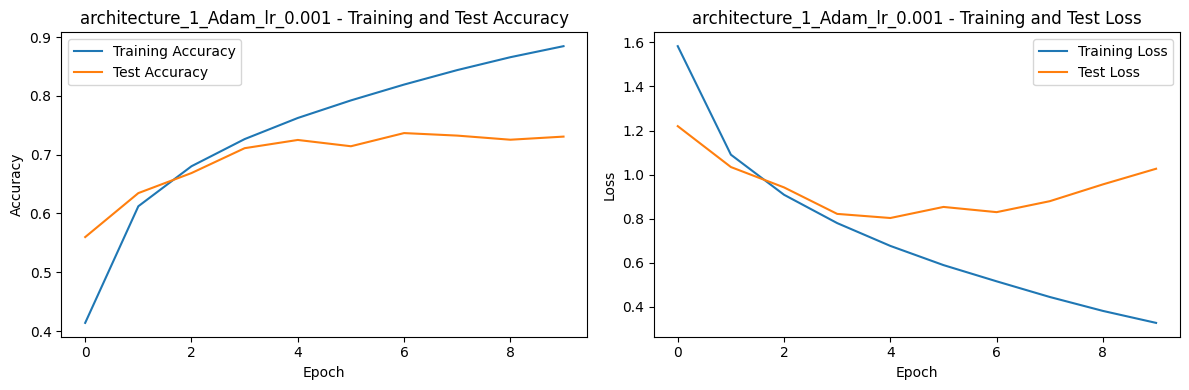

Epoch 1/10
782/782 [==============================] - 11s 12ms/step - loss: 2.3007 - accuracy: 0.0904 - val_loss: 2.2978 - val_accuracy: 0.1065
Epoch 2/10
782/782 [==============================] - 8s 10ms/step - loss: 2.2942 - accuracy: 0.1222 - val_loss: 2.2887 - val_accuracy: 0.1445
Epoch 3/10
782/782 [==============================] - 9s 12ms/step - loss: 2.2778 - accuracy: 0.1597 - val_loss: 2.2610 - val_accuracy: 0.1715
Epoch 4/10
782/782 [==============================] - 9s 11ms/step - loss: 2.2299 - accuracy: 0.1817 - val_loss: 2.2005 - val_accuracy: 0.1927
Epoch 5/10
782/782 [==============================] - 9s 12ms/step - loss: 2.1762 - accuracy: 0.2058 - val_loss: 2.1546 - val_accuracy: 0.2267
Epoch 6/10
782/782 [==============================] - 9s 11ms/step - loss: 2.1256 - accuracy: 0.2413 - val_loss: 2.0926 - val_accuracy: 0.2642
Epoch 7/10
782/782 [==============================] - 8s 10ms/step - loss: 2.0587 - accuracy: 0.2758 - val_loss: 2.0171 - val_accuracy: 0.296

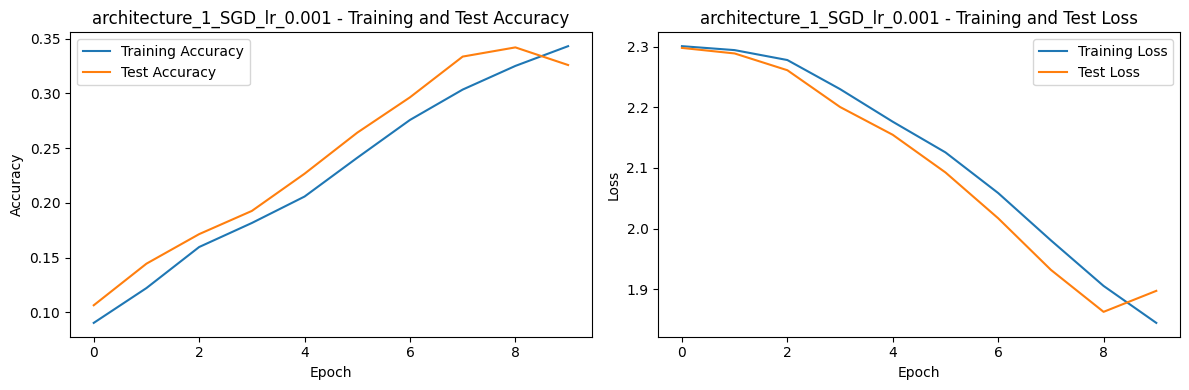

Epoch 1/10
782/782 [==============================] - 11s 11ms/step - loss: 1.5541 - accuracy: 0.4317 - val_loss: 1.2320 - val_accuracy: 0.5530
Epoch 2/10
782/782 [==============================] - 8s 10ms/step - loss: 1.0829 - accuracy: 0.6131 - val_loss: 1.0331 - val_accuracy: 0.6316
Epoch 3/10
782/782 [==============================] - 9s 12ms/step - loss: 0.8913 - accuracy: 0.6831 - val_loss: 0.8794 - val_accuracy: 0.6898
Epoch 4/10
782/782 [==============================] - 8s 11ms/step - loss: 0.7628 - accuracy: 0.7296 - val_loss: 0.8510 - val_accuracy: 0.7073
Epoch 5/10
782/782 [==============================] - 9s 12ms/step - loss: 0.6575 - accuracy: 0.7688 - val_loss: 0.8338 - val_accuracy: 0.7194
Epoch 6/10
782/782 [==============================] - 10s 12ms/step - loss: 0.5670 - accuracy: 0.8010 - val_loss: 0.8845 - val_accuracy: 0.7264
Epoch 7/10
782/782 [==============================] - 9s 12ms/step - loss: 0.4944 - accuracy: 0.8265 - val_loss: 0.8968 - val_accuracy: 0.72

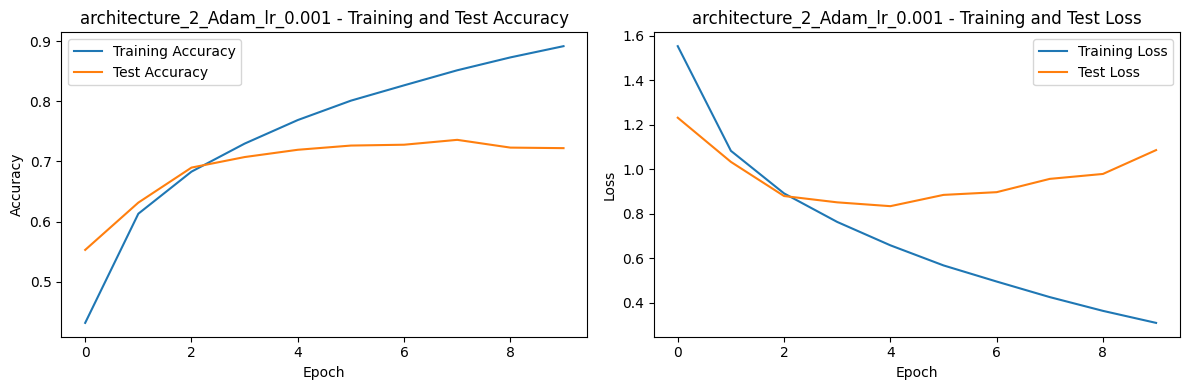

Epoch 1/10
782/782 [==============================] - 11s 12ms/step - loss: 2.2995 - accuracy: 0.1093 - val_loss: 2.2968 - val_accuracy: 0.1280
Epoch 2/10
782/782 [==============================] - 8s 10ms/step - loss: 2.2945 - accuracy: 0.1331 - val_loss: 2.2901 - val_accuracy: 0.1377
Epoch 3/10
782/782 [==============================] - 10s 12ms/step - loss: 2.2847 - accuracy: 0.1414 - val_loss: 2.2749 - val_accuracy: 0.1583
Epoch 4/10
782/782 [==============================] - 8s 11ms/step - loss: 2.2609 - accuracy: 0.1697 - val_loss: 2.2369 - val_accuracy: 0.1928
Epoch 5/10
782/782 [==============================] - 8s 10ms/step - loss: 2.2087 - accuracy: 0.2053 - val_loss: 2.1707 - val_accuracy: 0.2266
Epoch 6/10
782/782 [==============================] - 9s 12ms/step - loss: 2.1409 - accuracy: 0.2272 - val_loss: 2.0989 - val_accuracy: 0.2463
Epoch 7/10
782/782 [==============================] - 10s 12ms/step - loss: 2.0699 - accuracy: 0.2502 - val_loss: 2.0237 - val_accuracy: 0.2

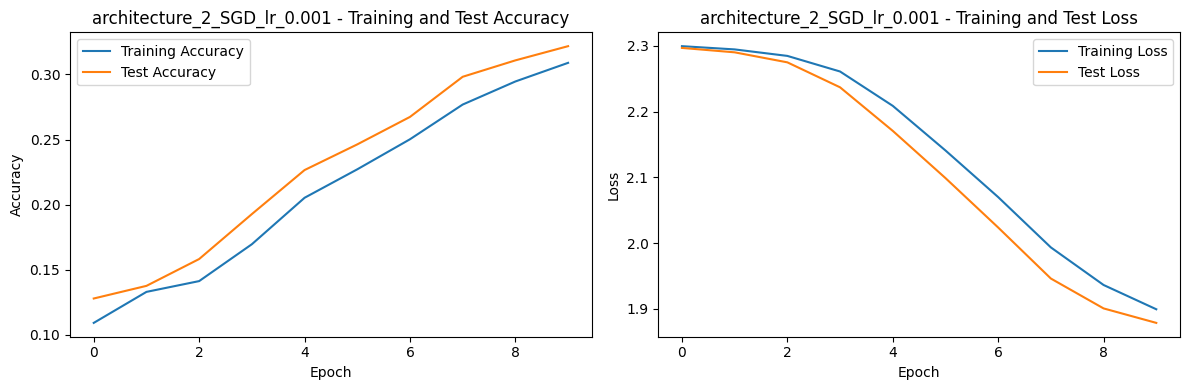

Epoch 1/10
782/782 [==============================] - 12s 13ms/step - loss: 1.7833 - accuracy: 0.3526 - val_loss: 1.6017 - val_accuracy: 0.4201
Epoch 2/10
782/782 [==============================] - 8s 10ms/step - loss: 1.4695 - accuracy: 0.4664 - val_loss: 1.3794 - val_accuracy: 0.4979
Epoch 3/10
782/782 [==============================] - 10s 13ms/step - loss: 1.3474 - accuracy: 0.5122 - val_loss: 1.3318 - val_accuracy: 0.5173
Epoch 4/10
782/782 [==============================] - 9s 11ms/step - loss: 1.2674 - accuracy: 0.5434 - val_loss: 1.2405 - val_accuracy: 0.5480
Epoch 5/10
782/782 [==============================] - 8s 10ms/step - loss: 1.2062 - accuracy: 0.5696 - val_loss: 1.1974 - val_accuracy: 0.5676
Epoch 6/10
782/782 [==============================] - 9s 12ms/step - loss: 1.1499 - accuracy: 0.5907 - val_loss: 1.1585 - val_accuracy: 0.5887
Epoch 7/10
782/782 [==============================] - 9s 11ms/step - loss: 1.0980 - accuracy: 0.6087 - val_loss: 1.1181 - val_accuracy: 0.60

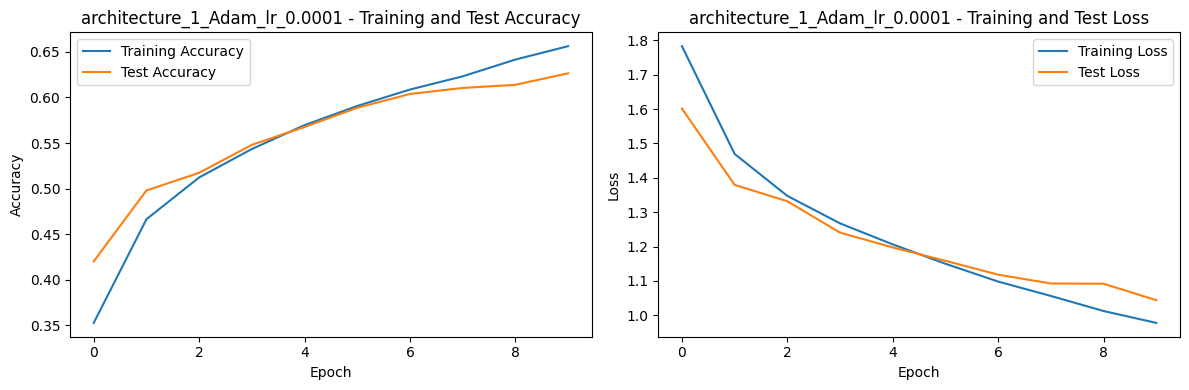

Epoch 1/10
782/782 [==============================] - 11s 11ms/step - loss: 2.3024 - accuracy: 0.0979 - val_loss: 2.3024 - val_accuracy: 0.0997
Epoch 2/10
782/782 [==============================] - 10s 12ms/step - loss: 2.3022 - accuracy: 0.1020 - val_loss: 2.3022 - val_accuracy: 0.1021
Epoch 3/10
782/782 [==============================] - 9s 11ms/step - loss: 2.3020 - accuracy: 0.1057 - val_loss: 2.3021 - val_accuracy: 0.1086
Epoch 4/10
782/782 [==============================] - 8s 10ms/step - loss: 2.3018 - accuracy: 0.1096 - val_loss: 2.3019 - val_accuracy: 0.1123
Epoch 5/10
782/782 [==============================] - 9s 12ms/step - loss: 2.3017 - accuracy: 0.1129 - val_loss: 2.3017 - val_accuracy: 0.1166
Epoch 6/10
782/782 [==============================] - 9s 11ms/step - loss: 2.3015 - accuracy: 0.1153 - val_loss: 2.3016 - val_accuracy: 0.1199
Epoch 7/10
782/782 [==============================] - 9s 11ms/step - loss: 2.3014 - accuracy: 0.1182 - val_loss: 2.3014 - val_accuracy: 0.12

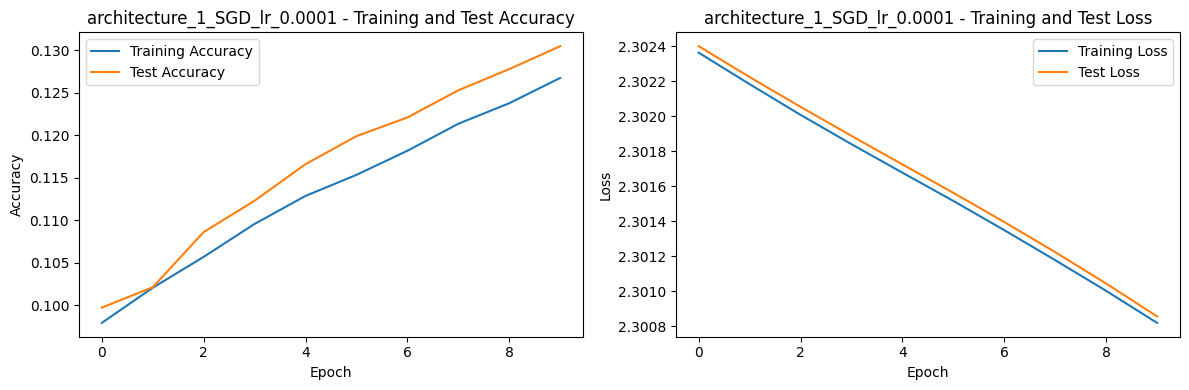

Epoch 1/10
782/782 [==============================] - 11s 11ms/step - loss: 1.7965 - accuracy: 0.3532 - val_loss: 1.5451 - val_accuracy: 0.4292
Epoch 2/10
782/782 [==============================] - 10s 13ms/step - loss: 1.4535 - accuracy: 0.4787 - val_loss: 1.3963 - val_accuracy: 0.4879
Epoch 3/10
782/782 [==============================] - 10s 13ms/step - loss: 1.3253 - accuracy: 0.5256 - val_loss: 1.2683 - val_accuracy: 0.5432
Epoch 4/10
782/782 [==============================] - 8s 11ms/step - loss: 1.2424 - accuracy: 0.5587 - val_loss: 1.2184 - val_accuracy: 0.5616
Epoch 5/10
782/782 [==============================] - 10s 13ms/step - loss: 1.1743 - accuracy: 0.5826 - val_loss: 1.1729 - val_accuracy: 0.5766
Epoch 6/10
782/782 [==============================] - 10s 13ms/step - loss: 1.1238 - accuracy: 0.6017 - val_loss: 1.1332 - val_accuracy: 0.5916
Epoch 7/10
782/782 [==============================] - 9s 11ms/step - loss: 1.0757 - accuracy: 0.6200 - val_loss: 1.0928 - val_accuracy: 0

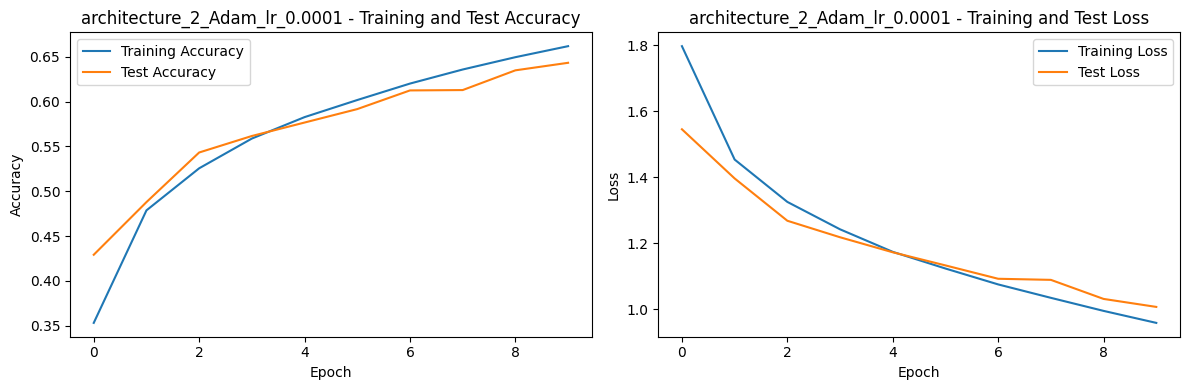

Epoch 1/10
782/782 [==============================] - 10s 11ms/step - loss: 2.3040 - accuracy: 0.1140 - val_loss: 2.3036 - val_accuracy: 0.1117
Epoch 2/10
782/782 [==============================] - 11s 13ms/step - loss: 2.3035 - accuracy: 0.1135 - val_loss: 2.3031 - val_accuracy: 0.1121
Epoch 3/10
782/782 [==============================] - 10s 12ms/step - loss: 2.3030 - accuracy: 0.1106 - val_loss: 2.3026 - val_accuracy: 0.1105
Epoch 4/10
782/782 [==============================] - 8s 10ms/step - loss: 2.3026 - accuracy: 0.1084 - val_loss: 2.3022 - val_accuracy: 0.1078
Epoch 5/10
782/782 [==============================] - 10s 13ms/step - loss: 2.3021 - accuracy: 0.1061 - val_loss: 2.3018 - val_accuracy: 0.1057
Epoch 6/10
782/782 [==============================] - 10s 13ms/step - loss: 2.3017 - accuracy: 0.1040 - val_loss: 2.3014 - val_accuracy: 0.1035
Epoch 7/10
782/782 [==============================] - 10s 13ms/step - loss: 2.3013 - accuracy: 0.1030 - val_loss: 2.3009 - val_accuracy: 

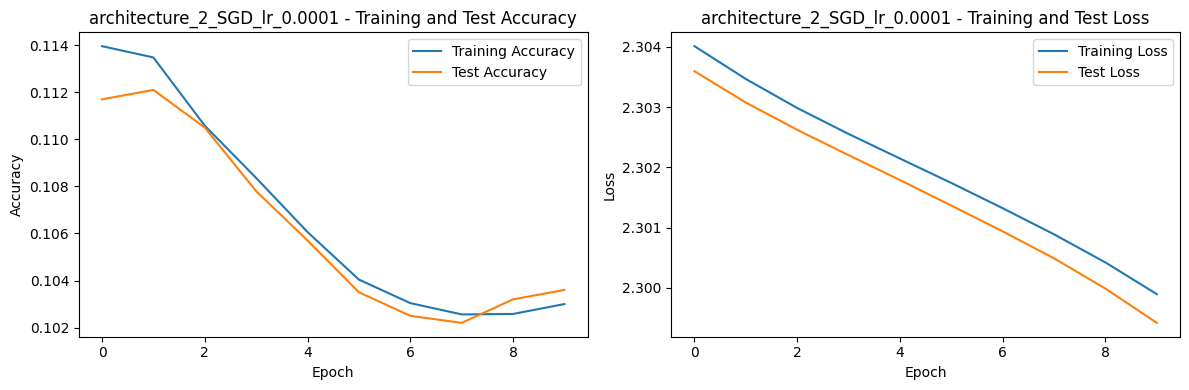

In [7]:
def train_and_evaluate(model, train_ds, test_ds, num_epochs, lr, optimizer, name):
    model.compile(optimizer=optimizer(learning_rate=lr),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(train_ds, epochs=num_epochs, validation_data=test_ds)

    # Plot training and test metrics
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title(f'{name} - Training and Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title(f'{name} - Training and Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Set hyperparameters
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000
NUM_EPOCHS = 10

# Load and preprocess the data
train_data, test_data = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)

# Experiment with different hyperparameters and architectures
def create_cnn_model_1(name='cnn_model_1'):
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)

    cnn_layer_1_1= tf.keras.layers.Conv2D(filters = 16, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_1_1(inputs)#shape: [batch_size, 32,32,16]

    cnn_layer_1_2= tf.keras.layers.Conv2D(filters = 16, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_1_2(x)#shape: [batch_size, 32,32,16]

    cnn_layer_pooling1 = tf.keras.layers.MaxPool2D()
    x= cnn_layer_pooling1(x)#shape: [batch_size, 16,16,16]

    cnn_layer_2_1= tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_2_1(x)#shape: [batch_size, 16,16,32]

    cnn_layer_2_2= tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_2_2(x)#shape: [batch_size, 16,16,32]

    cnn_layer_pooling2 = tf.keras.layers.MaxPool2D()
    x= cnn_layer_pooling2(x)#shape: [batch_size, 8,8,32]

    cnn_layer_3_1= tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_3_1(x)#shape: [batch_size, 8,8,64]

    cnn_layer_3_2= tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu',padding='same')
    x= cnn_layer_3_2(x)#shape: [batch_size, 8,8,64]

    cnn_layer_flatten = tf.keras.layers.Flatten()
    x= cnn_layer_flatten(x)# shape: [batch_size, 4096]

    dense_layer_1 = tf.keras.layers.Dense(64, activation = 'relu')
    x= dense_layer_1(x)#shape: [batch_size, 64]

    dense_layer_2 = tf.keras.layers.Dense(32, activation = 'relu')
    x= dense_layer_2(x)#shape: [batch_size, 32]

    output_layer = tf.keras.layers.Dense(10, activation = 'softmax')
    output = output_layer(x)#shape: [batch_size, 10]

    model = tf.keras.Model(inputs , output,name=name)

    return model

def create_cnn_model_2(name='cnn_model_2'):
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    output = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs , output,name=name)
    return model

architecture_1=create_cnn_model_1
architecture_2=create_cnn_model_2
learning_rates = [0.001, 0.0001]
architectures = ['architecture_1', 'architecture_2']  # You can experiment with different architectures
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]  # Experiment with different optimizers

for lr in learning_rates:
    for architecture in architectures:
        for optimizer in optimizers:
            model = create_my_cifar_cnn(name=f'{architecture}_{optimizer.__name__}_lr_{lr}')
            train_and_evaluate(model, train_data, test_data, NUM_EPOCHS, lr, optimizer, name=model.name)

In [8]:
# model = create_my_cifar_cnn()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])

# # Train the model using the custom training loop
# train_cifar_10(model, train_data, test_data, num_epochs=NUM_EPOCHS, lr=LR)